In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,  LSTM
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
# inputフォルダに格納されているファイルの一覧を出力
for dirname, _, filenames in os.walk('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input'):
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

# データを読み込み
item_categories = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/item_categories.csv')
items = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/items.csv')
sales_train = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sales_train.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sample_submission.csv')
shops = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/shops.csv')
test = pd.read_csv('/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/test.csv')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/item_categories.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/items.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sales_train.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sample_submission.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/shops.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/test.csv


In [3]:
sales_train_groupby = sales_train.drop(['date', 'item_price'], axis=1)
sales_train_groupby = sales_train_groupby.groupby(['date_block_num', 'shop_id', 'item_id']).sum().reset_index()

#sales_train_groupby.head(20)
sales_train['date_block_num'].min()

0

In [4]:
df = sales_train_groupby.sort_values(['shop_id', 'item_id', 'date_block_num'])
df = df.reset_index(drop=True)


#df = df[df.item_id == 20949]
#df = df[df.shop_id == 28]

#df.head(20)

In [5]:
test = test.sort_values(['shop_id', 'item_id'])
test = test.reset_index(drop=True)

test.head()

,ID,shop_id,item_id
0,22987,2,30
1,20994,2,31
2,20995,2,32
3,22492,2,33
4,22491,2,38


In [6]:
for index, row in test.iterrows():
    if index == 5:
        break
    print(row[1])
    print(row[2])
    for i in range(0, 35):
        if len(df[(df.date_block_num == i) & (df.shop_id == row[1]) & (df.item_id == row[2])]) == 0:
            df = df.append({'date_block_num': i, 'shop_id': row[1], 'item_id': row[2], 'item_cnt_day': 0.0}, ignore_index=True)

df = df.sort_values(['shop_id', 'item_id', 'date_block_num'])
df = df.reset_index(drop=True)


df.head(35)

2
30
2
31
2
32
2
33
2
38


,date_block_num,shop_id,item_id,item_cnt_day
0,1.0,0.0,30.0,31.0
1,1.0,0.0,31.0,11.0
2,0.0,0.0,32.0,6.0
3,1.0,0.0,32.0,10.0
4,0.0,0.0,33.0,3.0
5,1.0,0.0,33.0,3.0
6,0.0,0.0,35.0,1.0
7,1.0,0.0,35.0,14.0
8,1.0,0.0,36.0,1.0
9,1.0,0.0,40.0,1.0


In [7]:

L = len(df)
Y = df.iloc[:, 3]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

X1 = Y[0:L-5, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-4, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-3, :]  # 予測対象日の前日データ
X4 = Y[3:L-2, :]  # 予測対象日の前日データ
X5 = Y[4:L-1, :]  # 予測対象日の前日データ
Y = Y[5:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3, X4, X5], axis=1)  # numpy配列を結合する。

In [8]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

print(X)

[[[0.0232967  0.01450549 0.01230769 0.01406593 0.01098901]]

 [[0.01450549 0.01230769 0.01406593 0.01098901 0.01098901]]

 [[0.01230769 0.01406593 0.01098901 0.01098901 0.01010989]]

 ...

 [[0.01010989 0.01054945 0.01010989 0.01054945 0.01010989]]

 [[0.01054945 0.01010989 0.01054945 0.01010989 0.01010989]]

 [[0.01010989 0.01054945 0.01010989 0.01010989 0.01054945]]]


In [9]:
# train, testデータを定義
X_train = X[:20, :, :]
X_test = X[20:, :, :]
Y_train = Y[:20, :]
Y_test = Y[20:, :]

print(len(X_train))
print(len(X_test))

20
1609247


In [10]:
model = Sequential()
model.add(LSTM(10, 
               activation = 'tanh', 
               input_shape = (1,5), 
               recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

model.compile(loss= 'mean_squared_error', 
              optimizer = 'rmsprop', 
              metrics=[metrics.mae])
model.fit(X_train, Y_train, epochs=100, verbose=0)
Predict = model.predict(X_test)


In [11]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
#Y_train.index = pd.to_datetime(df.iloc[5:705,0])

Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
#Y_test.index = pd.to_datetime(df.iloc[705:,0])

Predict = scaler1.inverse_transform(Predict)
Predict = pd.DataFrame(Predict)
#Predict.index=pd.to_datetime(df.iloc[705:,0])

print(Y_test)
print(Predict)

           0
0        5.0
1        1.0
2        1.0
3        1.0
4        1.0
...      ...
1609242  2.0
1609243  1.0
1609244  1.0
1609245  2.0
1609246  1.0

[1609247 rows x 1 columns]
                0
0        2.141835
1       -0.812668
2        2.763458
3        0.764276
4       -0.170478
...           ...
1609242  0.134500
1609243  0.387382
1609244  0.139182
1609245  0.290320
1609246  0.275607

[1609247 rows x 1 columns]


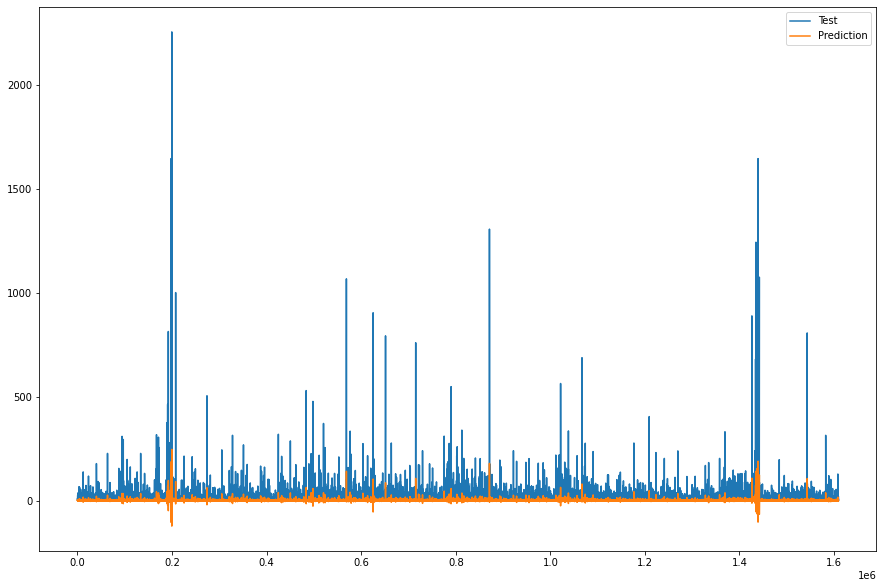

In [12]:
plt.figure(figsize=(15,10), facecolor='white')
plt.plot(Y_test, label = 'Test')
plt.plot(Predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()